# Why Julia is beautiful, but I probably will not switch from Python
*Where the sheer market share of Python makes it hard for me to justify switching to Julia* 

- I really find Julia interesting, have since the start in 2012
- But it is a very niche tool, a [poll I did on linkedin](https://www.linkedin.com/posts/paul-hiemstra-77030b20_ever-since-julia-stepped-out-onto-the-data-ugcPost-7033074528893173760-M0zC) had only 5 percent of people using Julia at all, with just 2 percent using Julia as their primary tool. 
- I want to give it an honest try, see if it would suit my needs

I have some requirements that define my current workflow:
- It has to run inside a container and VS Code
- Support for reading data from files: text files, CSV, Excel
- Support a dplyr like data flow where data and operations are chained top to bottom
- Support for a ggplot2 like plotting system
- Easily run basic ML algorithms: linear regression, Gradient Boosting, neural networks, etc

# Creating the development environment
- I tried looking for a pre-built Julia dev container, and found [this container](https://github.com/jupyter/docker-stacks/tree/main/datascience-notebook). The issue was that this container launched its own Jupyter server, which I could not get working with VS Code. I could launch a Jupyter server from `.devcontainer.json`, but this would make the experience very unstable. 
- Next I tried to install Julia inside an Anaconda3 container, which has most of the tooling I need already installed. Installing Julia via Conda turned out to not work for me, resulting in crashses. After a lot of tinkering I ended just downloading the prebuilt binaries inside the dockerfile and borrowing some code from the datascience-notebook to setup Julia for use with Jupyter. This worked a lot better. A downside is that the version of Julia is hardcoded right now. 
- I'm still stuck on the issue of package precompilation. When building the container, packages are precompiled. But when loading them the first time inside the jupyter environment, the precompilation is done again. This results in some waiting time in the order of 20-30 seconds. 
- I'm happy now with how the environment works, but getting it to work the way I wanted took a lot of time. There is no ready made Julia environment that works out of the box with VS Code. 

# Actually writing Julia code
The following Julia code reproduces the analyse of my [gas usage article](https://medium.com/towards-data-science/does-my-new-central-heating-boiler-help-with-these-crazy-high-gas-prices-b238fd623bba):

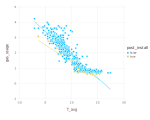

In [1]:
using StatsKit, DataFramesMeta, Dates, Gadfly, XLSX, GLM

knmi_data = @chain "knmi_weather.txt" begin
    CSV.File(comment="#", header=["station", "Datum", "T_avg", "T_min", "T_max"], 
             dateformat="yyyymmdd", types=Dict(:Datum => Date))   
    DataFrame()
    @transform(:T_avg = :T_avg / 10, :T_min = :T_min / 10, :T_max = :T_max / 10,
               :week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :T_avg=mean(:T_avg),          # Aggregate to week
                              :Datum=:Datum[1])             # Append the first date of the week
end

joined_weekly_mean = @chain "usage_anonymized.xlsx" begin
    XLSX.readtable("Sheet1", infer_eltypes = true)
    DataFrame()
    @transform(:week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :gas_usage=sum(:gas_usage),   # Aggregate to week
                              :Datum=:Datum[1],             # Append the first date of the week
                              :no_days=size(:Datum)[1])     # Append no days present in this week
    innerjoin(knmi_data, on=:Datum, makeunique=true)
    @subset(:gas_usage .>= 0.55, :no_days .== 7)            # Eliminate some obvious faulty values and weeks that do not have the full 7 days
    @transform(:post_install = :Datum .> Date("2022-05"))
end

set_default_plot_size(15cm, 12cm)
@chain joined_weekly_mean begin
    Gadfly.plot(x=:T_avg, y=:gas_usage, color=:post_install, Geom.point, Geom.smooth(method=:lm))
end

In [2]:
lm(@formula(gas_usage ~ T_avg * post_install), joined_weekly_mean)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gas_usage ~ 1 + T_avg + post_install + T_avg & post_install

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            3.39368    0.041646     81.49    <1e-99   3.31183     3.47554
T_avg                 -0.152191   0.00350507  -43.42    <1e-99  -0.15908    -0.145302
post_install          -0.889057   0.183482     -4.85    <1e-05  -1.24969    -0.528424
T_avg & post_install   0.0421465  0.0129811     3.25    0.0013   0.0166322   0.0676607
──────────────────────────────────────────────────────────────────────────────────────

Which nicely illustrates that we can replicate the full dplyr/ggplot2 workflow that I crave, including linear regression. 
- But sometimes small gripes. The syntax is not entirely ggplot2, in contrast to plotnine. This has me relearning stuff. Also, not all things are supported in Gadfly, e.g. facet_wrap is missing. It may be a small thing, but it add alot of friction. Why not use Python or R if I want the ggplot2 experience. 

I really like the consistent syntax, which is something that Pandas and python as a whole is not really good at. This is not surprsing as Julia is a niche language focused at just one field. Data science in Python is just one of the application areas. If feels that packages like Pandas grew over time from many contributors, adding code with a sligthly different style. Julia's community is just smaller, making a coherent vision across the language much more feasible. 

# Beyond regression
- Neural nets seem more barebone than using Keras. Stuff like downloading pretrained models seems to be more work [looking at this article](https://towardsdatascience.com/the-future-of-machine-learning-and-why-it-looks-a-lot-like-julia-a0e26b51f6a6). It is definitely not as easy to simply find tutorials that help you out, you always have to port them providing an additional hurdle. This could be very significant for novice users. 
- [A port of xgboost](https://github.com/dmlc/XGBoost.jl) is available in Julia, as are [wrappers for CatBoost](https://github.com/JuliaAI/CatBoost.jl). I have not tried these packages, but it seems that gradient boosting is supported in Julia just fine. Both of these pakages have had very recent activity on their github pages, which is a good sign that the project is not abandoned. 

So here we are a bit torn, there is lots of support, but it is not always as mature and supported by a large community. 

# Will I switch? 
Although I thoroughly enjoy working with Julia, and the code it allows me to write has a more consistent syntax, I can't make myself fully switch to Julia as my main tool. If I would swithc to anything, a switch to R would make much more sense. I also have a lot of experience in that. 
- The sheer momentum that Python has makes it hard for me to switch:
  - I have much more experience with Python already. Switching for me personally would involve a lot of work finding solutions to work I already did previsouly
  - All my students and co-workers use Python. This will make it hard to share my code with them, or for them to continue supporting it. 
  - The community around data science in Python is just so much larger. This means availability of tools, tutorials and such is just massively in favor of Python. This makes it hard for me to recommend it, espcially to a novice user. 
  - Many more employers are looking for people that can program Python than Julia. This makes Python a much better investment of time from this perspective. 
  - Python is a more complete language, making the time investment potentially pay more dividends outside the data science application. 